This notebook implements an RL agent that learns to navigate to a rewarded spatial location in a continuous space using actor-critic learning. This code was used for the RL modeling in the following paper: 

"Exploration biases how forelimb reaches to a spatial target are learned" by Alice Mosberger et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib notebook

<IPython.core.display.Javascript object>


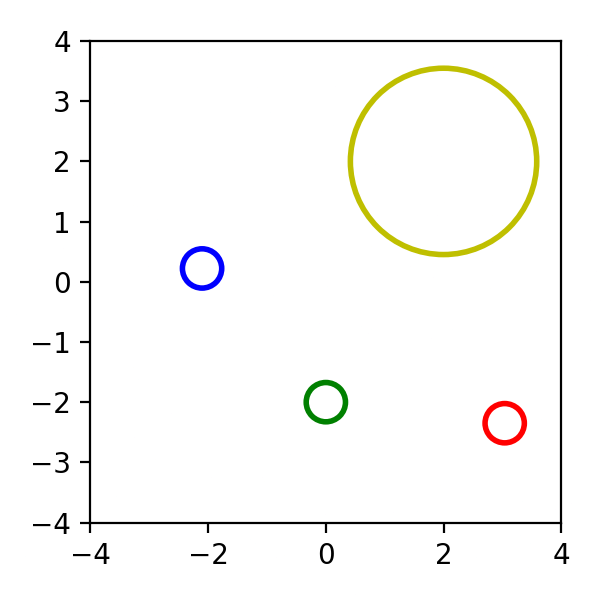

In [2]:
# Plot the home and target positions.

s_max = 4
home0 = np.array([0, -2])
target0 = np.array([2, 2])
target1 = np.array([-2, 2])
theta0 = np.arctan2(home0[1]-target0[1], home0[0]-target0[0])
dtheta = 400*np.pi/180
home_to_target = np.linalg.norm(home0 - target0)  # distance from home position to target
homeL = target0 + home_to_target*np.array([np.cos(theta0-dtheta), np.sin(theta0-dtheta)])
homeR = target0 + home_to_target*np.array([np.cos(theta0+dtheta), np.sin(theta0+dtheta)])

plt.figure(figsize=(3,3))
plt.scatter(home0[0], home0[1], s=200, facecolors='none', edgecolors='g', lw=2)
plt.scatter(homeL[0], homeL[1], s=200, facecolors='none', edgecolors='b', lw=2)
plt.scatter(homeR[0], homeR[1], s=200, facecolors='none', edgecolors='r', lw=2)
plt.scatter(target0[0], target0[1], s=4500, facecolors='none', edgecolors='y', lw=2)
plt.xlim(-s_max, s_max)
plt.ylim(-s_max, s_max)

plt.tight_layout()


In [5]:
def smooth(xx, window=5):
    '''Smooth a 1D array with a window of given size (which should be odd).'''
    xx_smooth = np.copy(xx)
    for ii in range(int(window/2-0.5), len(xx)-int(window/2-0.5)):
        xx_smooth[ii] = np.mean(xx[ii-int(window/2-0.5):ii+int(window/2-0.5)+1])

    return xx_smooth


class Agent:
    '''
    Create and train an agent using actor-critic learning to navigate to a goal location.
    '''
    def __init__(self, ):
        if True:  # initialize agents identically, but choose different actions for each agent.
            np.random.seed(0)
            self.rng = np.random.default_rng()
        self.noise = 1
        self.noise_corr = 3  # number of timesteps over which noise is correlated
        self.learning_rate = 1e-3
        self.go_signal_amplitude = 0
        self.t_max = 100  # max number of steps
        self.gamma = 0.99  # temporal discount factor
        self.na = 2  # dimension of action space
        self.ns = 5  # dimension of state space
        self.n_rbf = 100  # dimension of RBF state rep
        self.rbf_centers = -s_max + 2 * s_max * np.random.rand(self.n_rbf, 4)
        self.rbf_width = 2
        self.w = np.random.randn(self.na, self.n_rbf)/self.n_rbf**0.5  # policy weights
        self.v = np.random.randn(self.n_rbf)/self.n_rbf**0.5  # value estimation weights
        self.target = target0
        self.target_radius = 2
        self.states_list = []  # a list of state trajectories (one from each episode)
        
    def relu(self, x):
        return 0.5*(1 + np.sign(x))*x

    def rbf(self, s):
        '''
        Represent the 2D state in a radial basis function basis.
        '''
        state_rbf = np.array([np.exp(- 0.5 * np.linalg.norm(s[:self.ns-1] - self.rbf_centers[i,:])**2 / self.rbf_width**2) 
                              for i in range(self.n_rbf-1)])
        state_rbf = np.append(state_rbf, s[-1])
        return state_rbf

    def choose_action(self, s_rbf):
        a_det = self.w @ s_rbf
        self.a_var = (1 - 1 / self.noise_corr) * self.a_var
        #self.a_var += self.noise * np.random.randn(self.na) / self.noise_corr
        self.a_var += self.noise * self.rng.normal(size=self.na) / self.noise_corr
        return a_det + self.a_var, a_det
    
    def observe_reward(self, s, a):
        a0 = 100  # penalize actions with norm larger than this
        a_penalty = self.relu(np.linalg.norm(a) - a0)
        if np.linalg.norm(s[:2] - self.target) < self.target_radius:
            return 1 - a_penalty
        else:
            return -1 / self.t_max - a_penalty
        
    def value(self, s_rbf):
        return self.v @ s_rbf
    
    def update_value_weights(self, s_rbf, delta):
        grad_v = s_rbf
        self.z_v = 0.9 * self.gamma * self.z_v + grad_v
        self.v += self.learning_rate * delta * self.z_v
        
    def update_policy_weights(self, s_rbf, a, a_det, delta, t):
        grad_w = np.outer(a - a_det, s_rbf)
        self.z_w = 0.9 * self.gamma * self.z_w + self.gamma**t * grad_w
        self.w += self.learning_rate * delta * self.z_w / self.noise**2 \
                    - 0.01 * self.learning_rate * self.w
        
    def run_episode(self, home_pert=None):
        r_total = 0  # sum of rewards for this episode
        self.a_var = self.noise * np.random.randn(self.na)  # random part of the action at t=0
        self.z_v, self.z_w = 0, 0  # eligibility traces for value and policy weights
        
        # Initialize state: 
        if home_pert is not None:
            self.s = np.concatenate((home_pert, np.zeros(3)))  
        else:
            self.s = np.concatenate((home0, np.zeros(3)))  # initialize state
        states = np.reshape(self.s[:4], (1, self.ns-1))
        
        for t in range(self.t_max):
            if t == 0:
                self.s[-1] = self.go_signal_amplitude  # Go signal
            s_rbf = self.rbf(self.s)
            a, a_det = self.choose_action(s_rbf)
            pos_new = self.s[:2] + self.s[2:4]
            pos_new = np.clip(pos_new, -s_max, s_max)
            vel_new = 0.9 * self.s[2:4] + 0.1 * a
            for i in range(len(pos_new)):  # stop at the box boundaries
                if abs(pos_new[i]) > s_max:
                    pos_new[i] *= s_max / abs(pos_new[i])
                    vel_new[i] = 0
            s_new = np.concatenate((pos_new, vel_new, [0]))
            states = np.vstack((states, s_new[:-1]))
            r = self.observe_reward(s_new, a)
            delta = r + self.gamma * self.value(self.rbf(s_new)) - self.value(s_rbf)
            r_total += r
            self.update_value_weights(s_rbf, delta)
            self.update_policy_weights(s_rbf, a, a_det, delta, t)
            self.s = s_new
            if r > 0 or t == self.t_max - 1:
                self.states_list.append(states)
                return t, r_total, states
            
    def run_session(self, n_episodes):
        t_list, r_list, traj_list = [], [], []
        traj_pert_list = []
        for i in range(n_episodes):
            t, r, traj = self.run_episode()
            t_list.append(t)
            r_list.append(r)
            traj_list.append(traj)
            
        for i in range(10):
            _, _, traj = self.run_episode(home_pert=homeL)
            traj_pert_list.append(traj)
            _, _, traj = self.run_episode(home_pert=homeR)
            traj_pert_list.append(traj)
            
        return t_list, r_list, traj_list, traj_pert_list
            
    def occupancy(self, traj_list):
        # Concatenate all trajectories:
        traj_flat = np.zeros((0,4))
        for traj in traj_list:
            traj_flat = np.vstack((traj_flat, traj[2:,:]))  # omit the first two timesteps, before movement starts
        
        # Histogram bins:
        n_bins = 20
        bin_array = np.linspace(-s_max, s_max, n_bins+1)
        
        # Masks for bin_array that are True at the perturbed target positions:
        hL, _, _ = np.histogram2d([homeL[0]], [homeL[1]], bins=bin_array)
        maskL = np.array(hL, dtype=bool)
        hR, _, _ = np.histogram2d([homeR[0]], [homeR[1]], bins=bin_array)
        maskR = np.array(hR, dtype=bool)

        # Compute the occupancy for all spatial positions:
        occ, _, _ = np.histogram2d(traj_flat[:,0], traj_flat[:,1], bins=bin_array)

        # Compute the occupancy at the perturbed home positions:
        occ_homepert = np.reshape(np.array([occ[maskL], occ[maskR]]), (-1,))

        occ = occ[:,::-1]  # flip along the y direction for plotting
        occ = occ[1:-1, 1:-1]  # omit the edges, since agents spend a disproportionate amount of time there
        
        return occ, occ_homepert
        
    def entry_angles(self, traj_list):
        # The angles at which the target is entered in hit trials:
        final_angle_list = []
        for i, traj in enumerate(traj_list):
            if r_list[i] > 0:
                final_step = traj[-1,:2] - traj[-2,:2]  # difference between the last two positions in hit trials
                final_angle_list.append(np.arctan2(final_step[1], final_step[0]))
        for i, theta in enumerate(final_angle_list):
            if theta < 0:
                final_angle_list[i] += 2 * np.pi  # results should be between 0 and 2*pi
        return final_angle_list
    
    def home_perturbations(self, ):
        # Vectors from home positions to target0:
        dL = target0 - homeL
        dR = target0 - homeR
        d0 = target0 - home0
        
        # Probe the agent's action (without noise) at the three home positions:
        _, a0 = agent.choose_action(agent.rbf(np.append(home0, np.array([0,0,1]))))
        _, aL = agent.choose_action(agent.rbf(np.append(homeL, np.array([0,0,1]))))
        _, aR = agent.choose_action(agent.rbf(np.append(homeR, np.array([0,0,1]))))
        
        # Normalize to get unit vectors:
        dL /= np.linalg.norm(dL)
        dR /= np.linalg.norm(dR)
        a0 /= np.linalg.norm(a0)
        aL /= np.linalg.norm(aL)
        aR /= np.linalg.norm(aR)
        
        gammaL = abs(np.arccos(a0 @ dL)) * 180 / np.pi
        gammaR = abs(np.arccos(a0 @ dR)) * 180 / np.pi
        wL = gammaL / (gammaL + gammaR)
        wR = gammaR / (gammaL + gammaR)
        
        delta_optL = abs(np.arccos(dL @ aL)) * 180 / np.pi
        delta_optR = abs(np.arccos(dR @ aR)) * 180 / np.pi
        delta_origL = abs(np.arccos(a0 @ aL)) * 180 / np.pi
        delta_origR = abs(np.arccos(a0 @ aR)) * 180 / np.pi
        
        betaL = wL * (delta_optL - delta_origL)
        betaR = wR * (delta_optR - delta_origR)
        rho = 0.5 * (betaL + betaR)

        if False:
            # Overlaps of the above actions with the ideal directions from unperturbed and perturbed home positions: 
            Lpert_overlaps = np.array([aL @ a0 / (np.linalg.norm(aL) * np.linalg.norm(a0)),
                                      aL @ dL / (np.linalg.norm(aL) * np.linalg.norm(dL))])
            Rpert_overlaps = np.array([aR @ a0 / (np.linalg.norm(aR) * np.linalg.norm(a0)),
                                      aR @ dR / (np.linalg.norm(aR) * np.linalg.norm(dR))])

            # If the quantities below are positive (negative), agent is an "endpoint" ("direction") learner:
            Lpert_endpointlearnerness = Lpert_overlaps[1] - Lpert_overlaps[0]
            Rpert_endpointlearnerness = Rpert_overlaps[1] - Rpert_overlaps[0]
        
        return rho
      
def angular_std(x):
    '''
    Compute the angular std of a bunch of angles, following the approach described here:
    https://www.jstatsoft.org/article/view/v031i10
    
    Parameters
    --
    x : a list or 1D array of angles (in radians).
    
    Returns
    --
    ang_std : The angular standard deviation of how spread out the angles are.
    '''
    x = np.array(x)
    r = np.vstack((np.cos(x), np.sin(x))).T  # n_samples by 2
    r_mean = np.mean(r, axis=0)
    ang_var = 1 - np.linalg.norm(r_mean)
    ang_std = np.sqrt(2 * ang_var)
    return ang_std


def directional_variance(traj_list):
    '''
    Following Alice's approach, compute the mean directional variance across spatial bins,
    weighting each bin by its occupancy.
    
    N.B. This is a bit different from Alice's approach since, in the case where two 
    consecutive timesteps are within the same bin, she would sum the velocity vectors,
    while I include them as two separate contributions to the angular std.
    '''
    # Concatenate trajectories:
    traj_concat = traj_list[0]
    for traj in traj_list[:-20]:
        traj_concat = np.append(traj_concat, traj, axis=0)

    # Histogram bins:
    n_bins = 20
    bin_array = np.linspace(-s_max, s_max, n_bins+1)

    # For each bin, compute the occupancy and the angular std of velocities within that bin:
    occ_list = []
    angstd_list = []
    for i in range(n_bins):
        for j in range(n_bins):
            mask = (traj_concat[:,0] > bin_array[i]) * (traj_concat[:,0] < bin_array[i+1]) \
                    * (traj_concat[:,1] > bin_array[j]) * (traj_concat[:,1] < bin_array[j+1])
            if np.sum(mask) > 2:
                occ_list.append(np.sum(mask))
                vel_bin = traj_concat[mask][:,2:]
                angle_bin = np.arctan2(vel_bin[:,0], vel_bin[:,1])
                for k, angle in enumerate(angle_bin):
                    if angle < 0:
                        angle_bin[k] += 2 * np.pi
                angstd_list.append(angular_std(angle_bin))
                
    return np.sum(np.array(occ_list) * np.array(angstd_list)) / np.sum(np.array(occ_list))


def make_plots(r_list, t_list, traj_list, traj_pert_list, occupancy):

    plt.figure(figsize=(11,7))

    plt.subplot(231)
    plt.plot(smooth(r_list, 21))
    plt.xlabel('Steps')
    plt.ylabel('Reward')

    plt.subplot(232)
    plt.plot(smooth(t_list, 21))
    plt.xlabel('Steps')
    plt.ylabel('Steps to target')

    plt.subplot(233)
    plt.imshow(np.log(1 + occupancy).T, extent=(-s_max, s_max, -s_max, s_max))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(234)
    for i in range(1,11):
        plt.plot(traj_list[i][:,0], traj_list[i][:,1], '-', alpha = 0.75)
    plt.plot(home0[0], home0[1], 'xr', ms=12, mew=6, alpha=0.5)
    plt.plot(target0[0], target0[1], 'or', ms=80, alpha=0.5)
    plt.xlim(-s_max, s_max)
    plt.ylim(-s_max, s_max)
    plt.xticks([])
    plt.yticks([])
    plt.title('Early')

    plt.subplot(235)
    for i in range(1,11):
        plt.plot(traj_list[-i][:,0], traj_list[-i][:,1], '-', alpha = 0.75)
    plt.plot(home0[0], home0[1], 'xr', ms=12, mew=6, alpha=0.5)
    plt.plot(target0[0], target0[1], 'or', ms=80, alpha=0.5)
    plt.xlim(-s_max, s_max)
    plt.ylim(-s_max, s_max)
    plt.xticks([])
    plt.yticks([])
    plt.title('Late')

    plt.subplot(236)
    for i in range(1,21):
        plt.plot(traj_pert_list[-i][:,0], traj_pert_list[-i][:,1], '-', alpha = 0.75)
    plt.plot(homeL[0], homeL[1], 'xr', ms=12, mew=6, alpha=0.5)
    plt.plot(homeR[0], homeR[1], 'xr', ms=12, mew=6, alpha=0.5)
    plt.plot(target0[0], target0[1], 'or', ms=80, alpha=0.5)
    plt.xlim(-s_max, s_max)
    plt.ylim(-s_max, s_max)
    plt.xticks([])
    plt.yticks([])
    plt.title('Late')

    plt.tight_layout()

std(entry_angles_early, entry_angles_late) (0.5480436288699899, 0.19885354960092697)
(occupancy_frac_early, occupancy_frac_late):  (0.1372459433596541, 0.04141714123113125)
early occupancy at perturbed (L,R) home positions:  [16. 25.]
late occupancy at perturbed (L,R) home positions:  [0. 0.]
rho:  -17.02606257695299


<IPython.core.display.Javascript object>


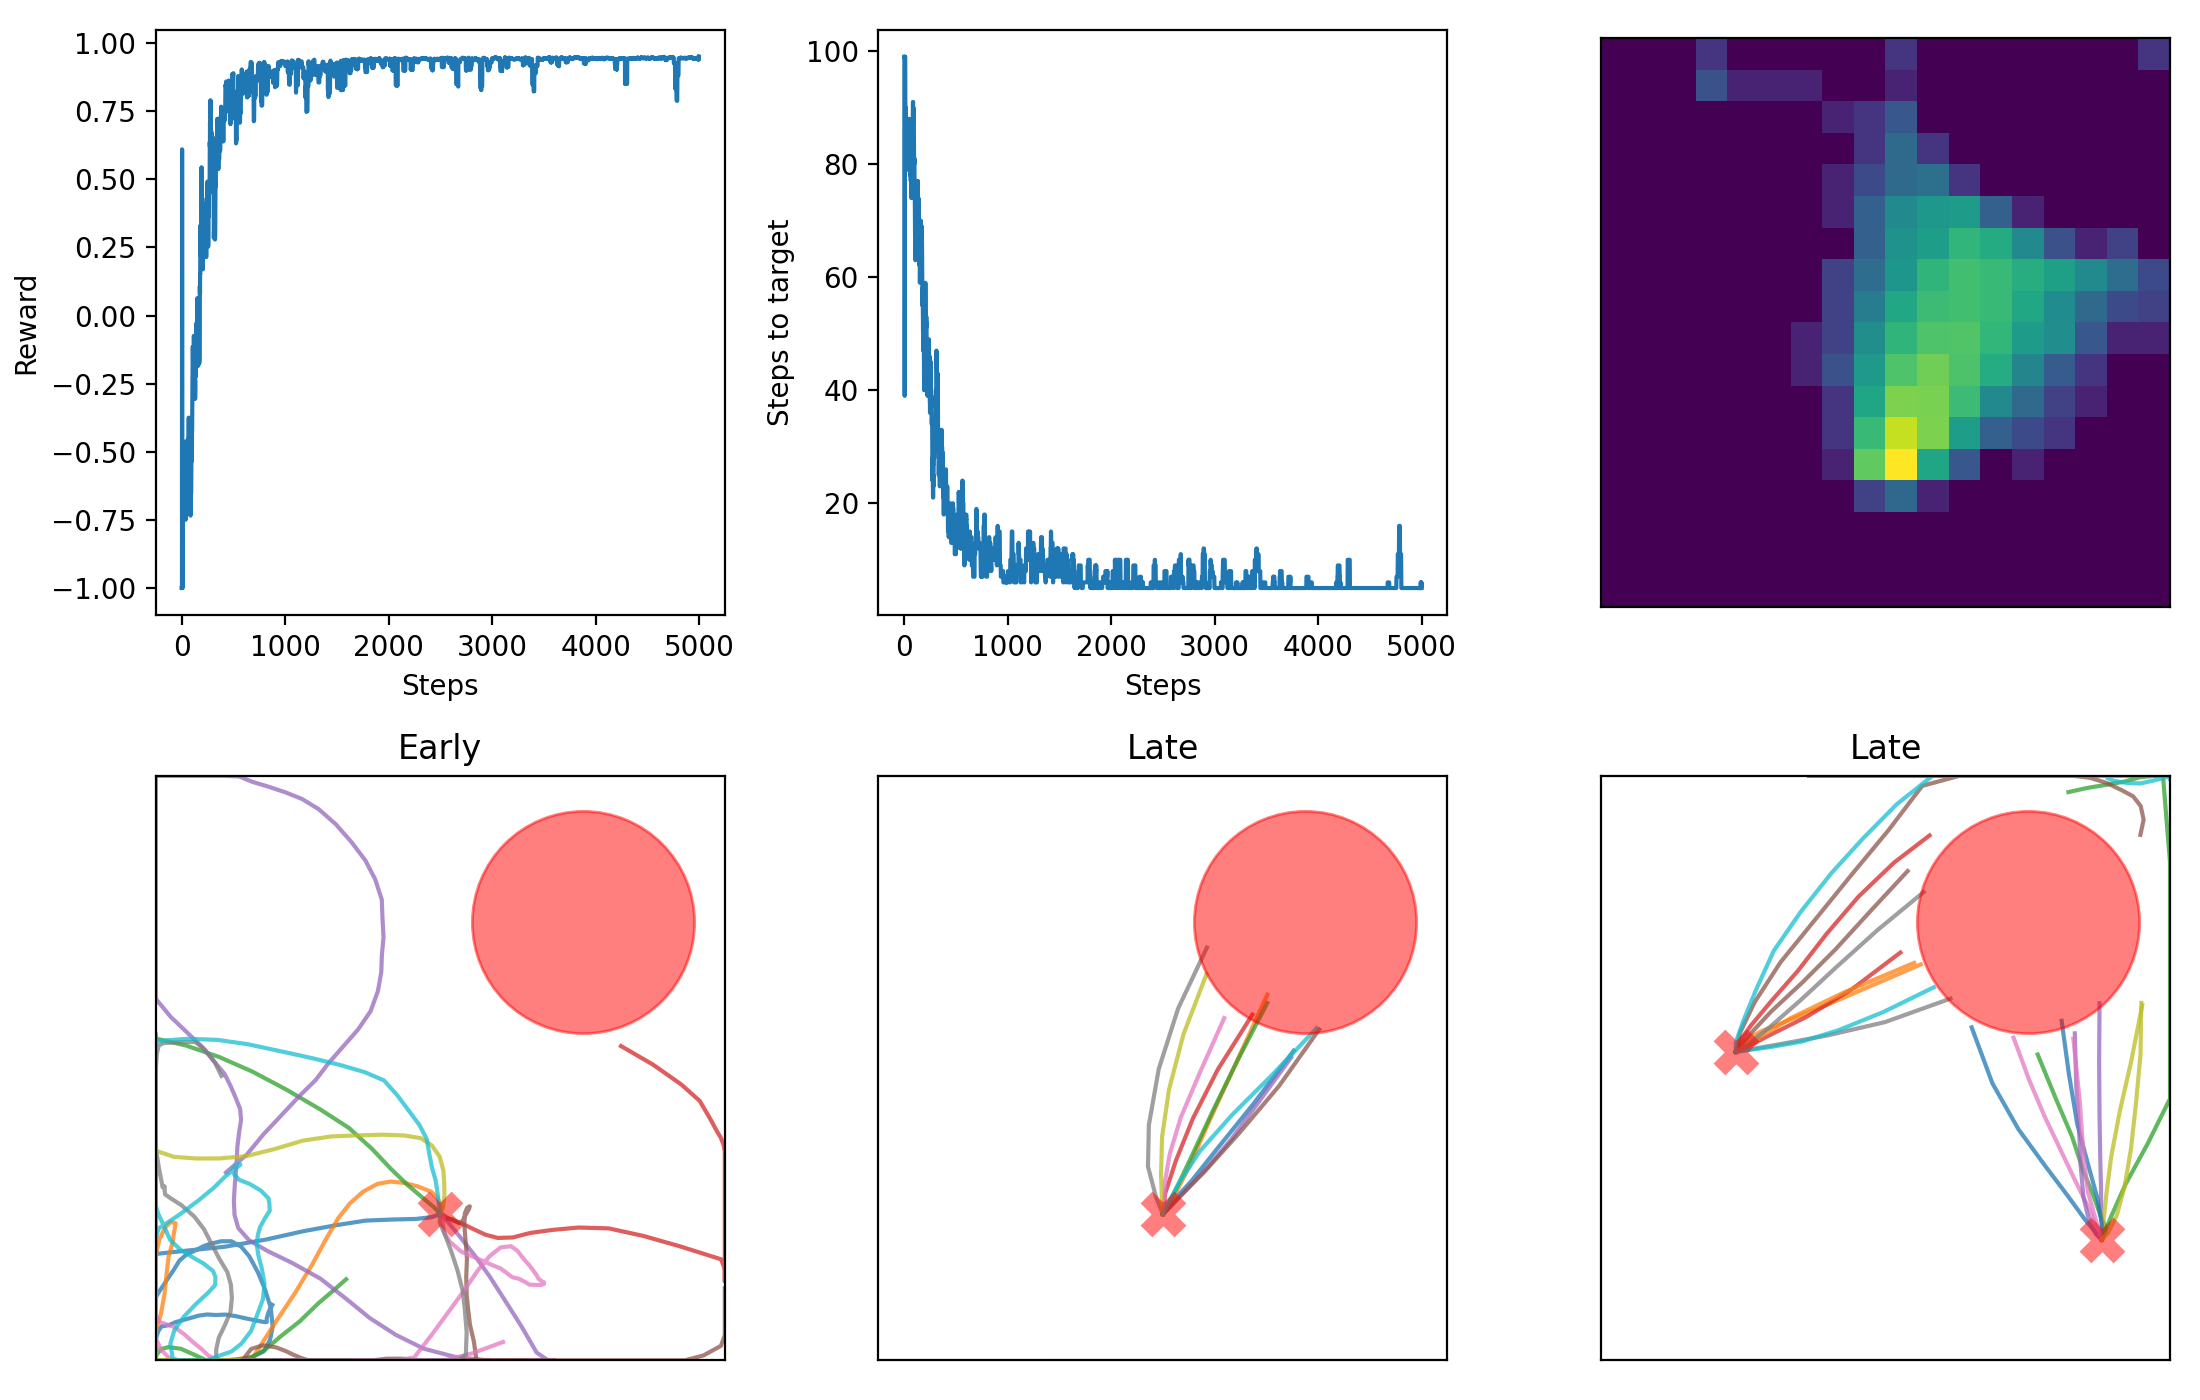

In [7]:
# Train an agent and plot its behavior. 

agent = Agent()
t_list, r_list, traj_list, traj_pert_list = agent.run_session(5000)
n_bins = 20  # number of spatial bins for computing occupancy metrics
occupancy_early, occ_homepert_early = agent.occupancy(traj_list[:len(traj_list)//4])
occupancy_frac_early = 1 / n_bins**2 * np.sum(occupancy_early)**2 / np.sum(occupancy_early**2)
occupancy_late, occ_homepert_late = agent.occupancy(traj_list[-len(traj_list)//4:])
occupancy_frac_late = 1 / n_bins**2 * np.sum(occupancy_late)**2 / np.sum(occupancy_late**2)
entry_angles_early = agent.entry_angles(traj_list[:len(traj_list)//4])
entry_angles_late = agent.entry_angles(traj_list[-len(traj_list)//4:])
rho = agent.home_perturbations()
print('std(entry_angles_early, entry_angles_late)', (angular_std(entry_angles_early), angular_std(entry_angles_late)))
print('(occupancy_frac_early, occupancy_frac_late): ', (occupancy_frac_early, occupancy_frac_late))
print('early occupancy at perturbed (L,R) home positions: ', occ_homepert_early)
print('late occupancy at perturbed (L,R) home positions: ', occ_homepert_late)
print('rho: ', rho)

make_plots(r_list, t_list, traj_list, traj_pert_list, occupancy_late)

#plt.savefig('example_agent.pdf')
